In [1]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import network_io as nio
from itertools import combinations
import random

## Create subsets 

In [11]:
import itertools

# List of 20 districts (represented as integers 1 to 20, can be replaced with actual district names)
districts = list(range(1, 21))

# Find all combinations of districts with a maximum of 2 districts
combinations = []
for r in range(2, 7):  # r is the number of districts in the combination (1 or 2)
    combinations.extend(itertools.combinations(districts, r))

# Print the combinations
# for combo in combinations:
#     print(combo)

# If you want to know the total number of combinations:
print(f"Total number of combinations: {len(combinations)}")

Total number of combinations: 60439


In [70]:
import random
import numpy as np
import matplotlib.pyplot as plt

# List of 20 districts (represented as integers 1 to 20)
districts = list(range(1, 21))

# Function to generate 50,000 unique subsets with sizes following a normal distribution
def generate_unique_subsets(districts, mean=4, std_dev=3, target_size=50000):
    unique_subsets = set()
    
    while len(unique_subsets) < target_size:
        # Generate a random subset size from a normal distribution, round to the nearest integer
        subset_size = max(1, int(np.random.normal(mean, std_dev)))
        
        # Ensure that subset size does not exceed the number of available districts
        subset_size = min(subset_size, len(districts))
        
        # Randomly sample districts for the subset
        subset = tuple(sorted(random.sample(districts, subset_size)))
        
        # Add the subset to the set of unique subsets
        unique_subsets.add(subset)
    
    return list(unique_subsets)

# Generate 50,000 unique subsets
unique_subsets = generate_unique_subsets(districts, mean=6, std_dev=1, target_size=80000)

# Check the number of unique subsets
print(f"Number of unique subsets: {len(unique_subsets)}")

Number of unique subsets: 80000


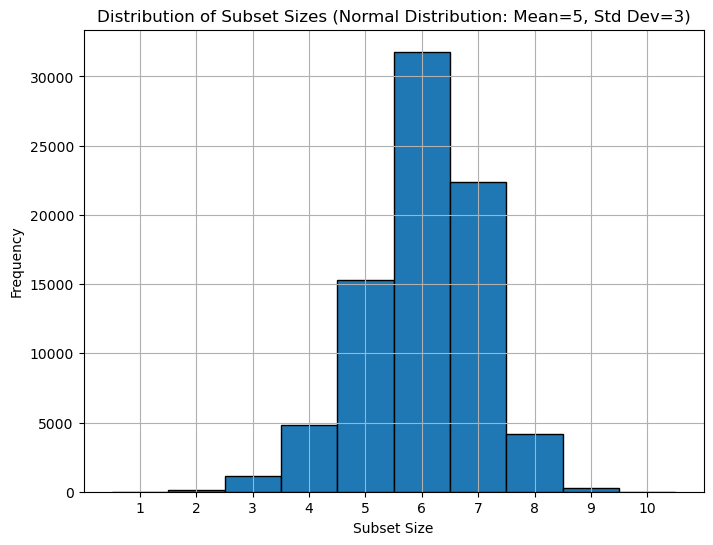

In [71]:
# Extract the sizes of the subsets
subset_sizes = [len(subset) for subset in unique_subsets]

# Plot the distribution of subset sizes
plt.figure(figsize=(8, 6))
plt.hist(subset_sizes, bins=range(1, max(subset_sizes)+2), align='left', edgecolor='black')
plt.title('Distribution of Subset Sizes (Normal Distribution: Mean=5, Std Dev=3)')
plt.xlabel('Subset Size')
plt.ylabel('Frequency')
plt.xticks(range(1, max(subset_sizes)+1))
plt.grid(True)
plt.show()

In [8]:
# Generate combinations of the form 1, (1,2), (1,2,3), ..., 2, (2,3), (2,3,4), ..., up to 20
# for i in range(1, 21):
#     random_subset.add((i))
    
# random_subset.add((1,2,3,4))
# random_subset.add((5,6,7))

In [10]:
# Save the random_subset list to a file using pickle
with open('subset_5000_comb.pkl', 'wb') as file:
    pickle.dump(random_subset, file)

In [12]:
import os
import gc
import random
import pandas as pd
import gzip
import xml.etree.ElementTree as ET

# Directory to save the files
output_base_dir = '../../../data/pop_1pct_with_policies/networks/'

# Number of files per directory
files_per_dir = 100

# Function to write XML to a compressed .gz file
def write_xml_to_gz(xml_tree, file_path):
    with gzip.open(file_path, 'wb') as f:
        xml_tree.write(f, encoding='utf-8', xml_declaration=True)

# Ensure the base output directory exists
os.makedirs(output_base_dir, exist_ok=True)

# Create and save the networks
for i, combination in enumerate(random_subset):
    if isinstance(combination, int):
        combination = (combination,)
    df_copy = gdf_edges_with_highway.copy()
    df_copy['policy_introduced'] = df_copy['district'].apply(
        lambda districts: any(d in districts for d in combination)
    ) & df_copy.apply(
        lambda row: 'car' in row['modes'] and row['osm:way:highway'] in higher_order_roads, axis=1
    )
    # Modify freespeed and capacity based on the policy_introduced condition
    df_copy.loc[df_copy['policy_introduced'], 'capacity'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2

    # Determine the subdirectory based on the file index
    dir_index = (i // files_per_dir) + 1
    subdir_name = f"networks_{dir_index * files_per_dir}"
    output_dir = os.path.join(output_base_dir, subdir_name)
    
    # Create the subdirectory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Determine the filename based on the combination
    if len(combination) == 1:
        filename = f"network_d_{combination[0]}.xml.gz"
    else:
        filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
    # Convert the DataFrame to XML
    xml_tree = nio.dataframe_to_xml(df_copy, nodes_dict)
    
    # Write the XML to a compressed .gz file
    file_path = os.path.join(output_dir, filename)
    nio.write_xml_to_gz(xml_tree, file_path)

    # Clear the dataframe from memory
    del df_copy
    gc.collect()

# Example: Display the file paths of the saved files
output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
print(output_files)

['../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_2_5_10_11_12_13_19_20.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_2_3_5_6_7_11_13_14.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_2_3_5_6_8_10_11_15_16_18.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_3_4_5_7_8_11_13_14_16_18_19_20.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_2_5_6_7_8_10_13_14_16_18.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_2_4_5_6_10_12_13_17_18.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_5_6_8_9_10_15_16_17_18.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_2_4_5_8_10_11_13_15_16_17_19_20.xml.gz', '../../../data/pop_1pct_with_policies/networks/networks_3100/network_d_1_3_4_5_7_8_9_10_12_13_14_17_18_19.xml.gz', '../../../data/pop_1pct_with_p

In [ ]:
# dataframes = []
# for combination in random_subset:
#     # print(combination)
#     if isinstance(combination, int):
#         combination = (combination,)
#     df_copy = gdf_edges_with_highway.copy()
#     df_copy['policy_introduced'] = df_copy['district'].apply(
#         lambda districts: any(d in districts for d in combination)
#     ) & df_copy.apply(
#         lambda row: 'car' in row['modes'] and row['osm:way:highway'] in higher_order_roads, axis=1
#     )
#     # Modify freespeed and capacity based on the policy_introduced condition
#     df_copy.loc[df_copy['policy_introduced'], 'capacity'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2
#     dataframes.append(df_copy)
#     # print(df_copy['policy_introduced'].value_counts())

In [ ]:
# # Directory to save the files
# output_dir = '../../../data/pop_1pct_with_policies/networks/'
# os.makedirs(output_dir, exist_ok=True)

# # Create and save the networks
# for i, df in enumerate(dataframes):
#     # Determine the filename based on the combination
#     combination = random_subset[i]
#     if len(combination) == 1:
#         filename = f"network_d_{combination[0]}.xml.gz"
#     else:
#         filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
#     # Convert the DataFrame back to XML
#     xml_tree = nio.dataframe_to_xml(df, nodes_dict)
    
#     # Write the XML to a compressed .gz file
#     file_path = os.path.join(output_dir, filename)
#     nio.write_xml_to_gz(xml_tree, file_path)

# # Example: Display the file paths of the saved files
# output_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]

(1, 4, 7, 8, 9, 11, 12, 13, 14, 17, 18)
(3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 18)
(2, 3, 8, 10, 11, 12, 17, 18)
(1, 4, 5, 7, 9, 10, 13, 14, 16, 17, 18)
(1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 19)
(1, 2, 4, 5, 6, 9, 10, 12, 16, 17, 18, 19, 20)
(1, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 17, 19)
(1, 2, 3, 4, 8, 10, 11, 12, 13, 16, 19, 20)
(4, 6, 7, 8, 9, 10, 11, 12, 13, 18)
(1, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20)
(1, 4, 5, 6, 11, 17, 18, 19, 20)
(2, 4, 5, 6, 8, 9, 11, 13, 15, 16)
(1, 2, 3, 5, 6, 7, 8, 9, 13, 15)
(1, 2, 3, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20)
(1, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 20)
(4, 5, 6, 7, 10, 11, 12, 16, 17, 18)
(1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20)
(1, 3, 4, 5, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20)
(1, 3, 6, 7, 10, 11, 12, 13, 16, 18)
(1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 17, 20)


In [ ]:
# import os
# import nio  # Assuming `nio` is a custom module or library you're using
# import random

# # Directory to save the files
# output_base_dir = '../../../data/pop_1pct_with_policies/networks/'

# # Number of files per directory
# files_per_dir = 100

# # Create and save the networks
# for i, df in enumerate(dataframes):
#     # Determine the subdirectory based on the file index
#     dir_index = (i // files_per_dir) + 1
#     subdir_name = f"networks_{dir_index * files_per_dir}"
#     output_dir = os.path.join(output_base_dir, subdir_name)
    
#     # Create the subdirectory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Determine the filename based on the combination
#     combination = random_subset[i]
#     if len(combination) == 1:
#         filename = f"network_d_{combination[0]}.xml.gz"
#     else:
#         filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
#     # Convert the DataFrame back to XML
#     xml_tree = nio.dataframe_to_xml(df, nodes_dict)
    
#     # Write the XML to a compressed .gz file
#     file_path = os.path.join(output_dir, filename)
#     nio.write_xml_to_gz(xml_tree, file_path)

# # Example: Display the file paths of the saved files
# output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
# print(output_files)
